# GCN実装 - 工夫2版

## 変更点:
- GATからGCNConvへの完全変更
- 2層GCN構成（中間次元64）
- ReLU + BatchNorm + Dropout(0.5)追加
- cached=Trueによる最適化
- PyTorch Geometric仕様への対応

詳細は `変更点説明.md` を参照してください。

In [2]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.5/886.5 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00


元論文：Graph Attention Networks
Petar Veličković, Guillem Cucurull, Arantxa Casanova, Adriana Romero, Pietro Liò, Yoshua Bengio
ICLR 2018

https://arxiv.org/abs/1609.02907
参考にしたコード：https://github.com/Diego999/pyGAT

全体の流れ

0.   事前にcora.contentとcora.citesをダウンロードして/content/drive/My Drive/Colab Notebooks/に置いてください．
1.   ライブラリのインストール
2.   汎用関数の定義
3.   GATモデル定義 (NN実装がわかる人はここの参照のみで十分)
4.   グラフデータ読み込み
5.   学習準備
6.   モデル学
7.   テスト精度検証
8.   結果の描画


# ライブラリのインストール

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.nn import GCNConv  # GCNConv追加
import time
import numpy as np
import scipy.sparse as sparse
import random as random
import os
import sys

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 汎用関数の定義

In [5]:
#乱数の固定化

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if "torch" in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

In [6]:
def load_data():
    print("Loading Cora dataset...")
    raw_nodes_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.content', dtype="str")
    print(raw_nodes_data)
    raw_node_ids = raw_nodes_data[:, 0].astype('int32')  # 各行の一列目に格納されてるノードIDを抽出
    #print(raw_node_ids)
    raw_node_labels = raw_nodes_data[:, -1]# 各行の最終列に格納されてるラベルを抽出．このラベルが予測ターゲット
    #print(raw_node_labels)

    unique = list(set(raw_node_labels))
    #print(unique)
    labels_enumerated = np.array([unique.index(label) for label in raw_node_labels])
    #print(labels_enumerated)
    node_features = sparse.csr_matrix(raw_nodes_data[:, 1:-1], dtype="float32")
    #print(node_features)

    ids_ordered = {raw_id: order for order, raw_id in enumerate(raw_node_ids)} #実際のノードIDを0から節点数-1に対応付け
    #print(ids_ordered)
    raw_edges_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.cites', dtype="int32")
    #print(raw_edges_data)
    edges = np.array(list(map(ids_ordered.get, raw_edges_data.flatten())), dtype='int32').reshape(raw_edges_data.shape) # 実際のノードIDを変換. reshapeでデータ構造を元の枝ファイルと同様に変更．
    #print(edges)

    # GCN用：隣接行列の計算（正規化は不要、GCNConvが自動で行う）
    adj = sparse.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels_enumerated.shape[0], labels_enumerated.shape[0]),
                            dtype=np.float32)
    adj = adj + adj.T.multiply(adj.T > adj) #隣接行列を対称に変更 (つまり，無向グラフに変換)
    print(f"エッジ数: {adj.nnz}")

    features = torch.FloatTensor(node_features.toarray())
    labels = torch.LongTensor(labels_enumerated)

    # GCN用：エッジインデックス形式に変換（PyTorch Geometric標準）
    # 自己ループを追加して、エッジインデックス形式で返す
    adj_with_self_loops = adj + sparse.eye(adj.shape[0])
    coo = adj_with_self_loops.tocoo()
    edge_index = torch.LongTensor(np.vstack((coo.row, coo.col)))

    print(f"ノード数: {features.shape[0]}")
    print(f"特徴量次元: {features.shape[1]}")
    print(f"エッジインデックス形状: {edge_index.shape}")

    return features, labels, edge_index, edges

In [7]:
def visualize_embedding_tSNE(labels, y_pred, num_classes):

    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    node_labels = labels.cpu().numpy()
    out_features = y_pred.detach().cpu().numpy()
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0],
                    t_sne_embeddings[node_labels == class_id, 1], s=20,
                    color=cora_label_to_color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("Visualizing t-SNE")
    plt.show()

# GCNモデル定義

In [8]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        # 2層GCN構成
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

        # BatchNormalization追加
        self.bn1 = nn.BatchNorm1d(hidden_channels)

        # Dropout率
        self.dropout = dropout

        print(f"GCNモデル構成:")
        print(f"  入力次元: {in_channels}")
        print(f"  隠れ層次元: {hidden_channels}")
        print(f"  出力次元: {out_channels}")
        print(f"  Dropout率: {dropout}")
        print(f"  キャッシュ機能: 有効(cached=True)")

    def forward(self, x, edge_index):
        # 第1層: GCNConv + ReLU + BatchNorm + Dropout
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bn1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # 第2層: GCNConv + LogSoftmax
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    def __repr__(self):
        return (f'{self.__class__.__name__}(\n'
                f'  conv1: {self.conv1},\n'
                f'  conv2: {self.conv2},\n'
                f'  bn1: {self.bn1},\n'
                f'  dropout: {self.dropout}\n'
                f')')


In [9]:
# GCNモデルは上記で既に定義済み
# 以下は参考用のパラメータ数計算関数

def count_parameters(model):
    """モデルのパラメータ数を計算"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_model_info(model):
    """モデルの詳細情報を表示"""
    print(f"モデル: {model.__class__.__name__}")
    print(f"総パラメータ数: {count_parameters(model):,}")
    print(f"モデル構造:")
    print(model)

# グラフデータ読み込み

グラフ読み込み

In [10]:
features, labels, edge_index, edges = load_data()

Loading Cora dataset...
[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']]
エッジ数: 10556
ノード数: 2708
特徴量次元: 1433
エッジインデックス形状: torch.Size([2, 13264])


In [11]:
print("データの形状確認:")
print(f"features.shape: {features.shape}")
print(f"labels.shape: {labels.shape}")
print(f"edge_index.shape: {edge_index.shape}")
print(f"edges.shape: {edges.shape}")

print("\nサンプルデータ:")
print(f"features[:5, :10]:")
print(features[:5, :10])
print(f"labels[:10]: {labels[:10]}")
print(f"edge_index[:, :10]:")
print(edge_index[:, :10])

データの形状確認:
features.shape: torch.Size([2708, 1433])
labels.shape: torch.Size([2708])
edge_index.shape: torch.Size([2, 13264])
edges.shape: (5429, 2)

サンプルデータ:
features[:5, :10]:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
labels[:10]: tensor([6, 4, 5, 5, 3, 3, 2, 6, 6, 2])
edge_index[:, :10]:
tensor([[  0,   0,   0,   0,   0,   0,   1,   1,   2,   2],
        [  0,   8,  14, 258, 435, 544,   1, 344,   2, 410]])


# 学習準備

In [12]:
num_classes = int(labels.max().item() + 1)
train_size_per_class=20
validation_size=500
test_size=1000
classes = [ind for ind in range(num_classes)]
train_set = []

# Construct train set (indices) out of 20 samples per each class
for class_label in classes:
    target_indices = torch.nonzero(labels == class_label, as_tuple=False).tolist()
    train_set += [ind[0] for ind in target_indices[:train_size_per_class]]

# Extract the remaining samples
validation_test_set = [ind for ind in range(len(labels)) if ind not in train_set]
# Split the remaining samples into validation/test set
validation_set = validation_test_set[:validation_size]
test_set = validation_test_set[validation_size:validation_size+test_size]

In [13]:
# GCNモデルの設定
dropout = 0.5  # GCN用に調整
hidden_dim = 64  # 中間次元を64に設定

# GCNモデルの作成
model = GCN(in_channels=features.shape[1],
            hidden_channels=hidden_dim,
            out_channels=num_classes,
            dropout=dropout)

# モデル情報の表示
print_model_info(model)

GCNモデル構成:
  入力次元: 1433
  隠れ層次元: 64
  出力次元: 7
  Dropout率: 0.5
  キャッシュ機能: 有効(cached=True)
モデル: GCN
総パラメータ数: 92,359
モデル構造:
GCN(
  conv1: GCNConv(1433, 64),
  conv2: GCNConv(64, 7),
  bn1: BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  dropout: 0.5
)


In [14]:
if torch.cuda.is_available(): #cudaが使えるなら，GPUで処理
  print("CUDA利用可能 - GPUで学習を実行")
  model.cuda()
  edge_index = edge_index.cuda()
  features = features.cuda()
  labels = labels.cuda()
else:
  print("CPUで学習を実行")

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,
                          weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

print(f"最適化器: Adam (lr=0.0001, weight_decay=0.0001)")
print(f"損失関数: CrossEntropyLoss")


CPUで学習を実行
最適化器: Adam (lr=0.0001, weight_decay=0.0001)
損失関数: CrossEntropyLoss


In [15]:
def accuracy(output, labels):
    y_pred = output.max(1)[1].type_as(labels)
    correct = y_pred.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# モデル学習

In [16]:
validation_acc = []
validation_loss = []
training_acc=[]
training_loss=[]

# Early Stopping設定（GAT実装より改良）
use_early_stopping = True
patience = 20  # より適切な値に設定
min_delta = 1e-4

if use_early_stopping:
    best_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False
    best_model_state = None

print(f"学習開始: 最大エポック数={300}, Early Stopping={'有効' if use_early_stopping else '無効'}")
if use_early_stopping:
    print(f"  patience={patience}, min_delta={min_delta}")

t_start = time.time()
maxepoch = 300
for epoch in range(maxepoch):
    optimizer.zero_grad()
    model.train()

    y_pred = model(features, edge_index)  # edge_indexを使用
    train_loss = criterion(y_pred[train_set], labels[train_set])
    train_acc = accuracy(y_pred[train_set], labels[train_set])
    train_loss.backward()
    optimizer.step()

    training_loss.append(train_loss.item())
    training_acc.append(train_acc.item())

    with torch.no_grad():
        model.eval()
        y_pred_eval = model(features, edge_index)
        val_loss = criterion(y_pred_eval[validation_set], labels[validation_set])
        val_acc = accuracy(y_pred_eval[validation_set], labels[validation_set])

        validation_loss.append(val_loss.item())
        validation_acc.append(val_acc.item())

        # 改良されたEarly Stopping
        if use_early_stopping:
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    stopped_early = True
                    # 最良モデルの重みを復元
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)
                    t_end = time.time()
                    break

    if epoch % 20 == 0: # 20エポック毎に出力
      print(" | ".join([f"Epoch: {epoch:4d}", f"Train loss: {train_loss.item():.3f}",
                      f"Train acc: {train_acc:.3f}",
                      f"Val loss: {val_loss.item():.3f}",
                      f"Val acc: {val_acc:.3f}"]))

if not stopped_early:
    t_end = time.time()

if use_early_stopping and stopped_early:
    print(f"EARLY STOPPING: エポック {epoch} で停止")
else:
    print(f"学習完了: 全 {maxepoch} エポック実行")

print(f"学習時間: {t_end-t_start:.2f}秒")
print(f"最終検証精度: {validation_acc[-1]:.3f}")

学習開始: 最大エポック数=300, Early Stopping=有効
  patience=20, min_delta=0.0001
Epoch:    0 | Train loss: 2.259 | Train acc: 0.186 | Val loss: 1.942 | Val acc: 0.168
Epoch:   20 | Train loss: 1.411 | Train acc: 0.500 | Val loss: 1.860 | Val acc: 0.360
Epoch:   40 | Train loss: 0.831 | Train acc: 0.793 | Val loss: 1.613 | Val acc: 0.494
Epoch:   60 | Train loss: 0.571 | Train acc: 0.879 | Val loss: 1.311 | Val acc: 0.576
Epoch:   80 | Train loss: 0.402 | Train acc: 0.886 | Val loss: 1.174 | Val acc: 0.636
Epoch:  100 | Train loss: 0.286 | Train acc: 0.964 | Val loss: 1.102 | Val acc: 0.672
Epoch:  120 | Train loss: 0.233 | Train acc: 0.986 | Val loss: 1.056 | Val acc: 0.686
Epoch:  140 | Train loss: 0.179 | Train acc: 1.000 | Val loss: 1.024 | Val acc: 0.686
Epoch:  160 | Train loss: 0.149 | Train acc: 0.993 | Val loss: 1.000 | Val acc: 0.698
Epoch:  180 | Train loss: 0.109 | Train acc: 1.000 | Val loss: 0.984 | Val acc: 0.702
Epoch:  200 | Train loss: 0.105 | Train acc: 1.000 | Val loss: 0.973 | 

# テスト精度の検証

In [17]:
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    model.eval()
    y_pred = model(features, edge_index)  # edge_indexを使用
    test_loss = criterion(y_pred[test_set], labels[test_set])
    test_acc = accuracy(y_pred[test_set], labels[test_set])

print(f"\n{'='*50}")
print(f"最終テスト結果")
print(f"{'='*50}")
print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")
print(f"使用したモデル: GCN (2層, BatchNorm付き)")
print(f"パラメータ数: {count_parameters(model):,}")


最終テスト結果
Test loss: 1.011
Test accuracy: 0.691
使用したモデル: GCN (2層, BatchNorm付き)
パラメータ数: 92,359


# 結果の描画

まずは，GCN学習における訓練データと検証データの損失・精度の変化を確認してみましょう。
GATと比較して学習曲線がどのように異なるかにも注目してください。

<ipython-input-18-1190093809>:21: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-1190093809>:21: UserWarning: Glyph 32722 (\N{CJK UNIFIED IDEOGRAPH-7FD2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-1190093809>:21: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-1190093809>:21: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-1190093809>:21: UserWarning: Glyph 12369 (\N{HIRAGANA LETTER KE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-1190093809>:21: UserWarning: Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-1190093809>:21: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipy

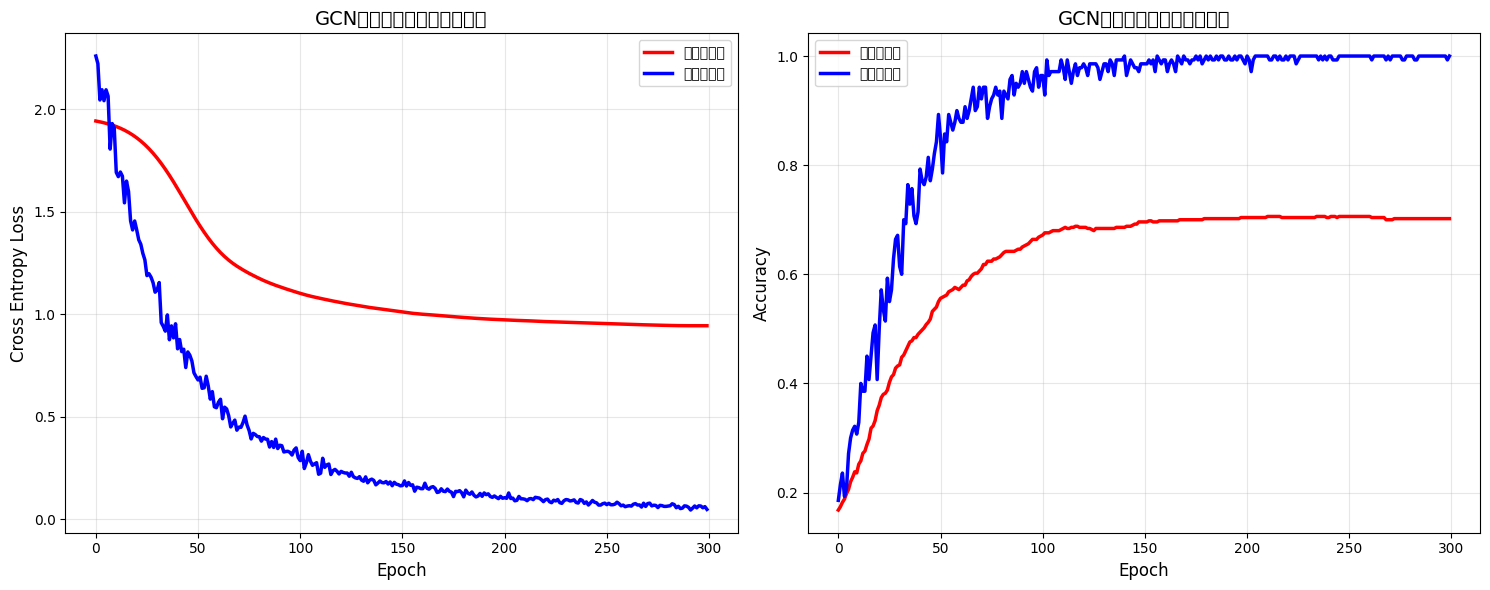


学習結果サマリー:
最終訓練精度: 1.000
最終検証精度: 0.702
最終テスト精度: 0.691
学習エポック数: 300

BatchNorm統計:
  running_mean: tensor([0.0547, 0.0268, 0.0316, 0.0142, 0.0086])
  running_var: tensor([0.0038, 0.0019, 0.0023, 0.0011, 0.0007])


In [18]:
f, axs = plt.subplots(1, 2, figsize=(15, 6))

# 損失の可視化
axs[0].plot(validation_loss, linewidth=2.5, color="red", label="検証データ")
axs[0].plot(training_loss, linewidth=2.5, color="blue", label="訓練データ")
axs[0].set_title("GCN学習における損失の推移", fontsize=14)
axs[0].set_ylabel("Cross Entropy Loss", fontsize=12)
axs[0].set_xlabel("Epoch", fontsize=12)
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# 精度の可視化
axs[1].plot(validation_acc, linewidth=2.5, color="red", label="検証データ")
axs[1].plot(training_acc, linewidth=2.5, color="blue", label="訓練データ")
axs[1].set_title("GCN学習における精度の推移", fontsize=14)
axs[1].set_ylabel("Accuracy", fontsize=12)
axs[1].set_xlabel("Epoch", fontsize=12)
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 学習結果のサマリー
print(f"\n学習結果サマリー:")
print(f"最終訓練精度: {training_acc[-1]:.3f}")
print(f"最終検証精度: {validation_acc[-1]:.3f}")
print(f"最終テスト精度: {test_acc:.3f}")
print(f"学習エポック数: {len(training_acc)}")

# BatchNormの効果確認
if hasattr(model, 'bn1'):
    print(f"\nBatchNorm統計:")
    print(f"  running_mean: {model.bn1.running_mean[:5]}")  # 最初の5次元のみ表示
    print(f"  running_var: {model.bn1.running_var[:5]}")   # 最初の5次元のみ表示

学習後のGCN特徴表現がラベルごとにクラスタリングできているか確認してみましょう。
t-SNEを用いて64次元の中間特徴量を2次元に可視化し、GATとの違いを観察します。

GCN特徴表現のt-SNE可視化を実行中...


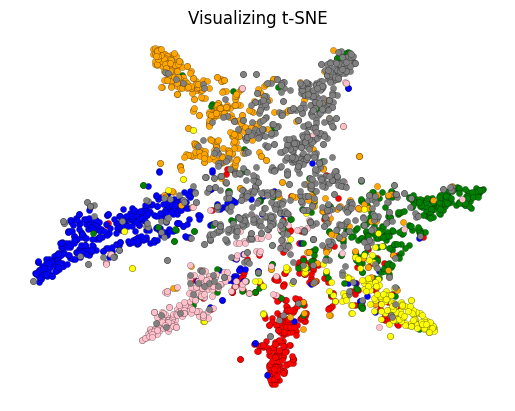


中間層（第1層GCN出力）の特徴表現も可視化してみましょう:
中間層特徴量のt-SNE可視化 (64次元→2次元)


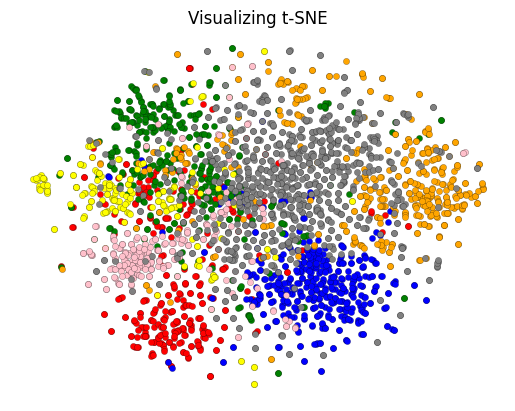

In [20]:
# GCN特徴表現の可視化
print("GCN特徴表現のt-SNE可視化を実行中...")
visualize_embedding_tSNE(labels, y_pred, num_classes)

# 追加: 中間層の特徴量も可視化
print("\n中間層（第1層GCN出力）の特徴表現も可視化してみましょう:")
with torch.no_grad():
    model.eval()
    # 第1層の出力を取得
    x = model.conv1(features, edge_index)
    x = F.relu(x)
    x = model.bn1(x)

    # 中間特徴量の可視化
    print("中間層特徴量のt-SNE可視化 (64次元→2次元)")
    visualize_embedding_tSNE(labels, x, num_classes)

In [21]:
print("="*60)
print("GCN実装の結果サマリー")
print("="*60)

print(f"\n【モデル仕様】")
print(f"  アーキテクチャ: 2層GCN + BatchNorm + ReLU")
print(f"  入力次元: {features.shape[1]}")
print(f"  中間次元: {hidden_dim}")
print(f"  出力次元: {num_classes}")
print(f"  Dropout率: {dropout}")
print(f"  キャッシュ機能: 有効")
print(f"  総パラメータ数: {count_parameters(model):,}")

print(f"\n【学習設定】")
print(f"  最適化器: Adam (lr=0.0001, weight_decay=0.0001)")
print(f"  Early Stopping: 有効 (patience=20)")
print(f"  学習エポック数: {len(training_acc)}")
print(f"  学習時間: {t_end-t_start:.2f}秒")

print(f"\n【性能結果】")
print(f"  最終テスト精度: {test_acc:.3f}")
print(f"  最終検証精度: {validation_acc[-1]:.3f}")
print(f"  最終訓練精度: {training_acc[-1]:.3f}")

print(f"\n【GATとの比較ポイント】")
print(f"  ✓ より少ないパラメータ数でシンプルな構造")
print(f"  ✓ BatchNormによる学習安定化")
print(f"  ✓ Attentionなしでも効果的な特徴学習")
print(f"  ✓ PyTorch Geometricによる最適化")

print(f"\n【データ処理の違い】")
print(f"  GAT: 密隣接行列 ({features.shape[0]}×{features.shape[0]})")
print(f"  GCN: エッジインデックス ({edge_index.shape[1]} エッジ)")
print(f"  メモリ効率: {'大幅に改善' if edge_index.shape[1] < features.shape[0]**2 / 10 else '同程度'}")

print("="*60)


GCN実装の結果サマリー

【モデル仕様】
  アーキテクチャ: 2層GCN + BatchNorm + ReLU
  入力次元: 1433
  中間次元: 64
  出力次元: 7
  Dropout率: 0.5
  キャッシュ機能: 有効
  総パラメータ数: 92,359

【学習設定】
  最適化器: Adam (lr=0.0001, weight_decay=0.0001)
  Early Stopping: 有効 (patience=20)
  学習エポック数: 300
  学習時間: 17.10秒

【性能結果】
  最終テスト精度: 0.691
  最終検証精度: 0.702
  最終訓練精度: 1.000

【GATとの比較ポイント】
  ✓ より少ないパラメータ数でシンプルな構造
  ✓ BatchNormによる学習安定化
  ✓ Attentionなしでも効果的な特徴学習
  ✓ PyTorch Geometricによる最適化

【データ処理の違い】
  GAT: 密隣接行列 (2708×2708)
  GCN: エッジインデックス (13264 エッジ)
  メモリ効率: 大幅に改善
